# Differential Peak Shape

**Created**: 14 April 2022

In [1]:
import os
import re

import pandas as pd
import numpy as np
import scipy.spatial.distance as scpd
import scipy.cluster.hierarchy as sch
import scipy.sparse.csgraph as sccs
import scipy.linalg as scl
import scipy.stats as scs
import scipy.interpolate as sci
import pyBigWig
import matplotlib.pyplot as plt

## Monocytes

In [28]:
peak_counts = pd.read_csv(
    '/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/cell_type_peak_sets/Monocytes_peak_counts.tsv',
    sep='\t', dtype={'Chr': str}
)

In [29]:
peak_counts.head()

,GeneID,Chr,Start,End,Strand,Calderon-1001-Monocytes-Control,Calderon-1001-Monocytes-Treatment_1,Calderon-1002-Monocytes-Treatment_1,Calderon-1003-Monocytes-Control,Calderon-1003-Monocytes-Treatment_1,Calderon-1004-Monocytes-Control,Calderon-1004-Monocytes-Treatment_1,Calderon-1008-Monocytes-Treatment_2,Calderon-1010-Monocytes-Treatment_2,Corces-4983-Monocytes-Control,Corces-6792-Monocytes-Control,Corces-7256-Monocytes-Control
0,1:817153-817495,1,817153,817495,+,62,77,38,27,27,61,44,58,86,62,56,148
1,1:819868-820327,1,819868,820327,+,75,47,18,34,18,51,90,89,33,0,2,2
2,1:821473-822877,1,821473,822877,+,218,197,86,63,94,151,140,113,113,10,16,28
3,1:827184-827801,1,827184,827801,+,124,137,68,40,46,132,111,88,136,76,34,130
4,1:869805-870210,1,869805,870210,+,204,121,77,52,42,144,75,97,126,81,30,49


In [2]:
peaks = pd.read_csv(
    "/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/cell_type_peak_sets/Monocytes.peaks.bed", sep="\t",
    names=['chr', 'start', 'end'],
    usecols=[0, 1, 2],
    dtype={'chr': str, 'start': int, 'end': int}
)

In [30]:
peaks.head()

,chr,start,end
0,1,817153,817495
1,1,819868,820327
2,1,821473,822877
3,1,827184,827801
4,1,869805,870210


In [3]:
immune_atlas = [
    x for x in os.listdir('/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/merged/atac_seq/')
    if ('Calderon' in x or 'Corces' in x) and 'Monocytes' in x
]

In [4]:
def hellinger(x, y):
    return (1 / np.sqrt(2)) * np.sqrt(np.power(np.sqrt(x) - np.sqrt(y), 2).sum())

In [5]:
regions = [list() for _ in range(len(peaks))]
for sample in immune_atlas:
    bw_file = pyBigWig.open(
        os.path.join('/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/merged/atac_seq/', sample, 'alignment', f'{sample}.bw')
    )
    for i, row in peaks.iterrows():
        values = np.array(bw_file.values(row.chr, row.start, row.end))
        values[np.isnan(values)] = 0
        if values.sum() > 0:
            values = values / values.sum()
        else:
            values = np.array([1 / (row.end - row.start)] * (row.end - row.start))
        regions[i].append(values)

In [6]:
distributions = [np.vstack(region) for region in regions]

In [69]:
pvalues = list()
max_distances = list()

vectors = list()
spectra = list()

stimulation = np.array([re.sub('^.*-', '', x) for x in immune_atlas])

control = stimulation == 'Control'
stimulated = stimulation != 'Control'

for distribution in distributions[0:10]:

    distances_condensed = scpd.pdist(distribution, hellinger)

    distances = scpd.squareform(distances_condensed)

    laplacian = sccs.laplacian(1 - distances, normed=True)

    eigenvalues, eigenvectors = scl.eig(laplacian)
    eigenvalues = np.real(eigenvalues)
    
    vectors.append(np.real(eigenvectors[:, 1]))
    
    sort_indices = np.argsort(eigenvalues)
    
    spectra.append(eigenvalues[sort_indices])
    eigenvectors = eigenvectors[:, sort_indices]

    pvalues.append(scs.mannwhitneyu(eigenvectors[control, 1], eigenvectors[stimulated, 1]).pvalue)
    max_distances.append(np.median(distances_condensed))
    
fiedler_vectors = np.transpose(np.vstack(vectors))
spectra = np.transpose(np.vstack(spectra))

['1:817153-817495',
 '1:819868-820327',
 '1:821473-822877',
 '1:827184-827801',
 '1:869805-870210',
 '1:903783-904174',
 '1:906246-907265',
 '1:912588-913024',
 '1:913424-913891',
 '1:914073-914490',
 '1:919563-920215',
 '1:920697-921744',
 '1:923311-925026',
 '1:926982-927679',
 '1:929725-931116',
 '1:936417-937341',
 '1:940883-942809',
 '1:947532-948819',
 '1:953329-954471',
 '1:958565-960058',
 '1:960428-962011',
 '1:962317-964432',
 '1:965835-968537',
 '1:970204-972474',
 '1:974452-974980',
 '1:975929-976630',
 '1:979240-979986',
 '1:980181-981133',
 '1:981451-982567',
 '1:996903-998703',
 '1:1002962-1003481',
 '1:1006451-1007078',
 '1:1012930-1014611',
 '1:1015355-1015750',
 '1:1019086-1020925',
 '1:1021100-1022471',
 '1:1031373-1032239',
 '1:1032370-1033705',
 '1:1033838-1034815',
 '1:1035658-1036204',
 '1:1038183-1039022',
 '1:1040438-1040943',
 '1:1046586-1047091',
 '1:1047919-1048387',
 '1:1049265-1050639',
 '1:1052875-1053494',
 '1:1053676-1054417',
 '1:1062245-1063049',
 '1:

In [79]:
pd.DataFrame(fiedler_vectors)

,0,1,2,3,4,5,6,7,8,9
0,-0.101495,-0.039921,0.067769,-0.411818,0.231048,0.053309,-0.242571,-0.193340,-0.104359,0.074397
1,0.219639,-0.423081,-0.122828,-0.026641,-0.008560,0.199151,0.108328,0.443139,-0.366305,-0.251325
2,-0.175936,-0.028490,0.046297,-0.148593,0.149507,0.063783,-0.093903,-0.279410,0.242737,0.109438
3,0.075635,0.079429,-0.255638,0.507155,-0.103195,0.025656,-0.231063,-0.159980,0.062710,0.144504
4,-0.241766,0.217879,-0.266204,0.259952,-0.065185,0.091461,-0.062108,-0.200036,0.190054,0.079601
5,-0.156345,0.243143,0.008950,-0.135308,0.085648,0.022368,-0.423348,0.139483,0.396901,0.204726
6,0.155821,-0.034844,0.525108,0.262962,0.232738,-0.682156,0.475058,0.528302,-0.365933,0.097113
7,0.373352,-0.030634,-0.133326,-0.466999,-0.463439,-0.003792,0.396511,-0.206228,0.099710,0.004005
8,-0.121649,0.035317,-0.105892,-0.182834,-0.034779,0.326001,-0.125065,-0.096017,0.054136,0.143042
9,0.566865,-0.652830,0.493435,0.133083,-0.366306,-0.603497,0.407388,0.479353,-0.507064,-0.607002


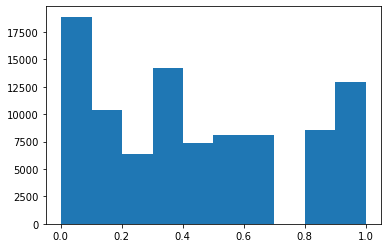

In [24]:
plt.hist(np.array(pvalues))
plt.show()

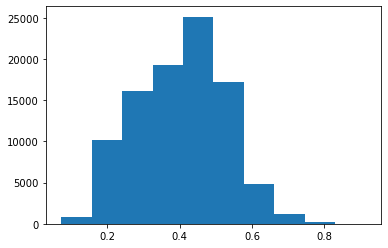

In [25]:
plt.hist(np.array(max_distances))
plt.show()

In [31]:
res = pd.DataFrame({'pvalues': pvalues, 'dist': max_distances})
res = res.sort_values(['dist', 'pvalues'], ascending=[False, True])

In [32]:
res[res['pvalues'] == np.min(pvalues)].head()

,pvalues,dist
73426,0.002165,0.767061
51021,0.002165,0.691640
19155,0.002165,0.670851
48173,0.002165,0.669016
45933,0.002165,0.637943


In [38]:
peak_idx = 19155

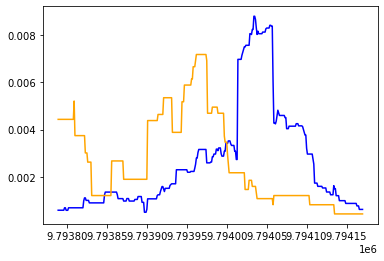

In [39]:
start = peaks.loc[peak_idx, 'start']
end = peaks.loc[peak_idx, 'end']

control_dist = np.sum(np.vstack([distributions[peak_idx][i] for i in range(len(immune_atlas)) if stimulation[i] == 'Control']), axis=0) / np.sum(np.array(stimulation) == 'Control')
plt.plot(np.arange(start, end, 1), control_dist, color='blue')

treatment_dist = np.sum(np.vstack([distributions[peak_idx][i] for i in range(len(immune_atlas)) if stimulation[i] != 'Control']), axis=0) / np.sum(np.array(stimulation) != 'Control')
plt.plot(np.arange(start, end, 1), treatment_dist, color='orange')

In [40]:
f"{peaks.loc[peak_idx,'chr']}:{peaks.loc[peak_idx,'start']}-{peaks.loc[peak_idx,'end']}"

'12:9793789-9794171'